# Task 1: Price Prediction

## Performing imports and reading the data

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

external_df = pd.read_csv(r'C:\Users\ariel\PycharmProjects\DMBD-Project-2023\data\timeseries\2015\external.csv')
global_df = pd.read_csv(r'C:\Users\ariel\PycharmProjects\DMBD-Project-2023\data\timeseries\2015\global.csv')
by_actor_df = pd.read_csv(r'C:\Users\ariel\PycharmProjects\DMBD-Project-2023\data\timeseries\2015\by_actor.csv')

external_df.sort_values(by=['week', 'weekday'], inplace=True)
global_df.sort_values(by=['week', 'weekday'], inplace=True)
by_actor_df.sort_values(by=['week', 'weekday'], inplace=True)

### Based on previous correlation analysis, we will use the following features:

In [16]:
by_actor_agg = by_actor_df.groupby(['week', 'weekday']).sum()[['received', 'spent']]

merged_df = external_df.merge(global_df[['week', 'weekday', 'nb_transactions', 'total_sent_satoshi', 'mean_feeUSD']], on=['week', 'weekday'], how='left')
merged_df = merged_df.merge(by_actor_agg, on=['week', 'weekday'], how='left')

for lag in range(1, 6):
    merged_df[f'PriceUSD_lag_{lag}'] = merged_df['PriceUSD'].shift(lag)

merged_df['PriceUSD_next_day'] = merged_df['PriceUSD'].shift(-1)
merged_df.dropna(inplace=True)

X = merged_df.drop(['PriceUSD', 'PriceUSD_next_day'], axis=1)
y = merged_df['PriceUSD_next_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

C:\Users\ariel\AppData\Local\Temp\ipykernel_27568\3918456123.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_actor_agg = by_actor_df.groupby(['week', 'weekday']).sum()[['received', 'spent']]


RMSE: 10.054898374617936


### Running it on the train data to see how it performs

C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with featur

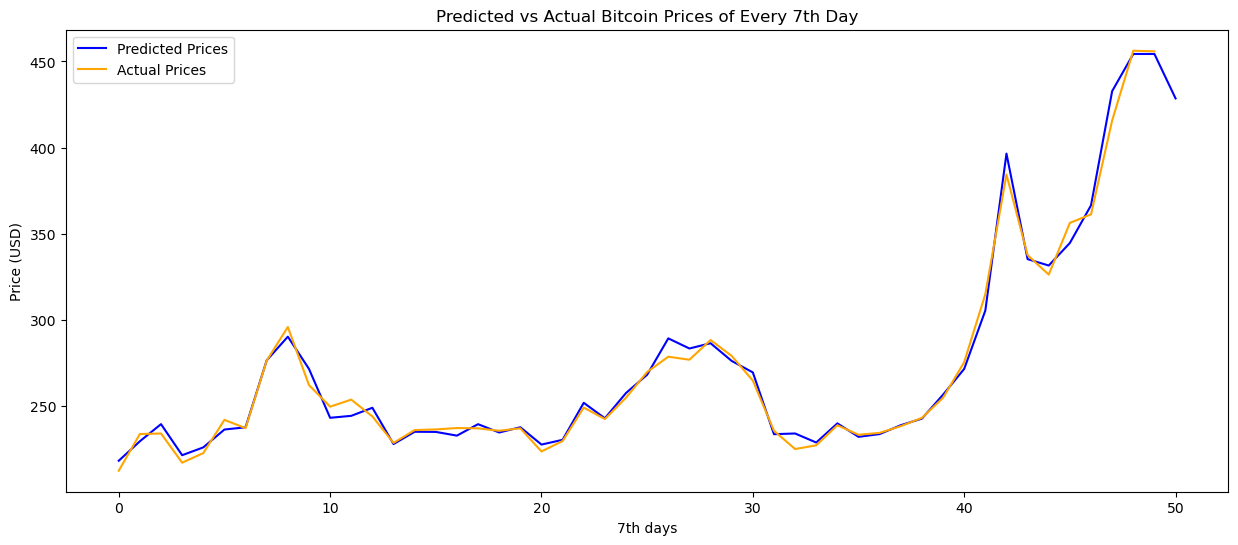

In [10]:
import matplotlib.pyplot as plt

def predict_seventh_day_price(model, data):
    predictions = []
    actual_values = []
    weeks = data['week'].unique()

    for week in weeks:
        week_data = data[data['week'] == week]
        if week_data.shape[0] >= 6:
            X_week = week_data.iloc[:6].drop(['PriceUSD', 'PriceUSD_next_day'], axis=1)
            prediction = model.predict([X_week.iloc[-1]])[0]
            actual_value = week_data.iloc[6]['PriceUSD'] if week_data.shape[0] > 6 else np.nan
            predictions.append(prediction)
            actual_values.append(actual_value)

    return predictions, actual_values

predicted_prices_rf, actual_prices = predict_seventh_day_price(regressor, merged_df)

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices_rf, label='Predicted Prices', color='blue')
plt.plot(actual_prices, label='Actual Prices', color='orange')
plt.xlabel('7th days')
plt.ylabel('Price (USD)')
plt.title('Predicted vs Actual Bitcoin Prices of Every 7th Day')
plt.legend()
plt.show()

### Using SVR

C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\skle

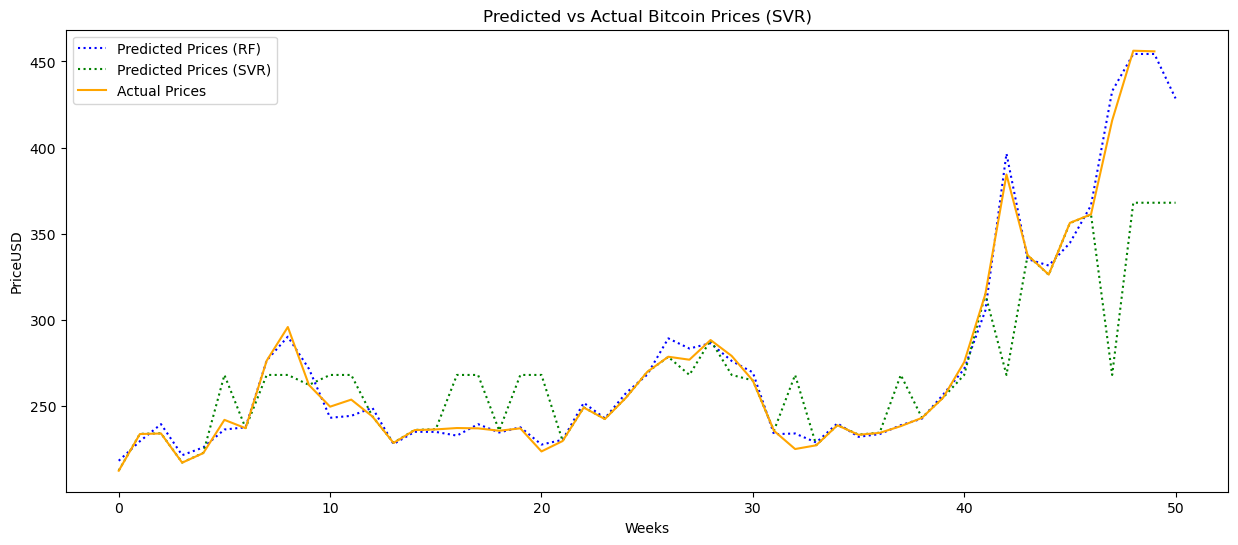

In [12]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)

def predict_seventh_day_price_svr(model, data):
    predictions = []
    actual_values = []
    weeks = data['week'].unique()

    for week in weeks:
        week_data = data[data['week'] == week]
        if week_data.shape[0] >= 6:
            X_week = week_data.iloc[:6].drop(['PriceUSD', 'PriceUSD_next_day'], axis=1)
            prediction = model.predict([X_week.iloc[-1]])[0]
            actual_value = week_data.iloc[6]['PriceUSD'] if week_data.shape[0] > 6 else np.nan

            predictions.append(prediction)
            actual_values.append(actual_value)

    return predictions, actual_values

predicted_prices_svr, actual_prices_svr = predict_seventh_day_price_svr(svr, merged_df)

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices_rf, 'b:', label='Predicted Prices (RF)')  
plt.plot(predicted_prices_svr, 'g:', label='Predicted Prices (SVR)') 
plt.plot(actual_prices_svr, 'orange', label='Actual Prices')
plt.xlabel('Weeks')
plt.ylabel('PriceUSD')
plt.title('Predicted vs Actual Bitcoin Prices (SVR)')
plt.legend()
plt.show()

To compare, let's also add the RMSE of both models

In [13]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

actual_prices_filtered_rf = [price for price in actual_prices if not np.isnan(price)]
predicted_prices_filtered_rf = predicted_prices_rf[:len(actual_prices_filtered_rf)]

actual_prices_filtered_svr = [price for price in actual_prices if not np.isnan(price)]
predicted_prices_filtered_svr = predicted_prices_svr[:len(actual_prices_filtered_svr)]

rmse_rf = calculate_rmse(actual_prices_filtered_rf, predicted_prices_filtered_rf)
rmse_svr = calculate_rmse(actual_prices_filtered_svr, predicted_prices_filtered_svr)

rmse_rf, rmse_svr


(5.500616055277552, 34.87373234187729)

### Using XGBoost

Index(['week', 'weekday', 'year', 'month', 'day', 'HashRate',
       'nb_transactions', 'total_sent_satoshi', 'mean_feeUSD', 'received',
       'spent', 'PriceUSD_lag_1', 'PriceUSD_lag_2', 'PriceUSD_lag_3',
       'PriceUSD_lag_4', 'PriceUSD_lag_5'],
      dtype='object')


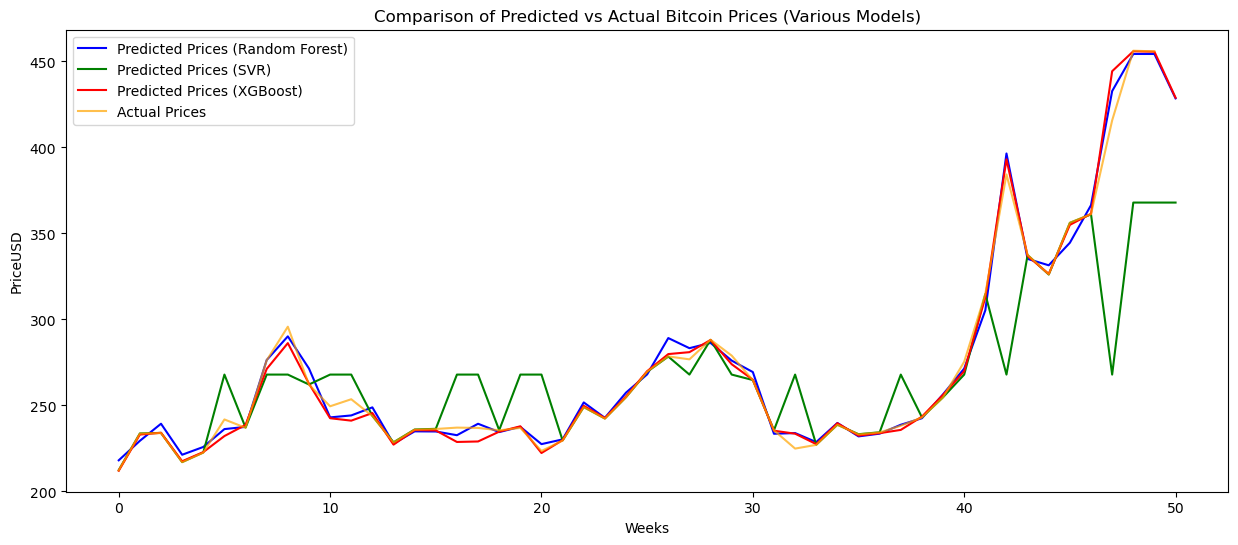

(5.500616055277552, 34.87373234187729, 5.68995538083765)

In [20]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)
print(X_train.columns)

def predict_seventh_day_pricexgb(model, data):
    predictions = []
    actual_values = []
    weeks = data['week'].unique()

    feature_names = model.get_booster().feature_names

    for week in weeks:
        week_data = data[data['week'] == week]
        if week_data.shape[0] >= 6:
            X_week = week_data[feature_names].iloc[:6]
            prediction = model.predict(X_week.iloc[-1].values.reshape(1, -1))[0]
            actual_value = week_data.iloc[6]['PriceUSD'] if week_data.shape[0] > 6 else np.nan
            predictions.append(prediction)
            actual_values.append(actual_value)

    return predictions, actual_values

predicted_prices_xgbr, actual_prices_xgbr = predict_seventh_day_pricexgb(xgbr, merged_df)

actual_prices_filtered_xgbr = [price for price in actual_prices_xgbr if not np.isnan(price)]
predicted_prices_filtered_xgbr = predicted_prices_xgbr[:len(actual_prices_filtered_xgbr)]

rmse_xgbr = calculate_rmse(actual_prices_filtered_xgbr, predicted_prices_filtered_xgbr)

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices_rf, label='Predicted Prices (Random Forest)', color='blue')
plt.plot(predicted_prices_svr, label='Predicted Prices (SVR)', color='green')
plt.plot(predicted_prices_xgbr, label='Predicted Prices (XGBoost)', color='red')
plt.plot(actual_prices, label='Actual Prices', color='orange', alpha=0.7)
plt.xlabel('Weeks')
plt.ylabel('PriceUSD')
plt.title('Comparison of Predicted vs Actual Bitcoin Prices (Various Models)')
plt.legend()
plt.show()

rmse_rf, rmse_svr, rmse_xgbr

## Franck's ARIMA

C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ariel\anaconda3\envs\Stage_M1_PIL\lib\site-packages\statsmodels\tsa\statespace\

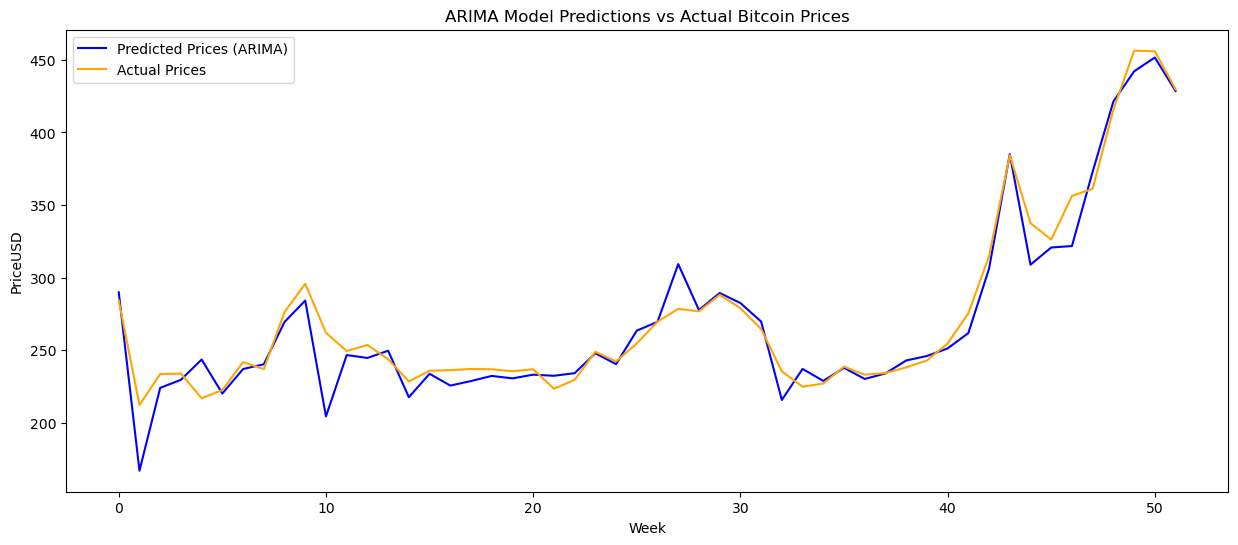

In [41]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(external_df['PriceUSD'], order=(3, 1, 1))
arima_result = arima_model.fit()

predicted_prices_arima = []
actual_prices_arima = []

unique_weeks = external_df['week'].unique()

for week in unique_weeks:
    week_data = external_df[external_df['week'] == week]['PriceUSD']

    if len(week_data) >= 6:
        model_temp = ARIMA(week_data.iloc[:6], order=(3, 1, 1))
        result_temp = model_temp.fit()
        
        forecast_temp = result_temp.forecast(steps=1)
        predicted_price = forecast_temp.iloc[0]
        predicted_prices_arima.append(predicted_price)

        actual_price = week_data.iloc[6] if len(week_data) == 7 else None
        actual_prices_arima.append(actual_price)

predicted_prices_arima = [p for p, a in zip(predicted_prices_arima, actual_prices_arima) if a is not None]
actual_prices_arima = [a for a in actual_prices_arima if a is not None]
predicted_prices_arima = predicted_prices_arima[1:] + [None]

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices_arima, label='Predicted Prices (ARIMA)', color='blue')
plt.plot(actual_prices_arima, label='Actual Prices', color='orange')
plt.xlabel('Week')
plt.ylabel('PriceUSD')
plt.title('ARIMA Model Predictions vs Actual Bitcoin Prices')
plt.legend()
plt.show()

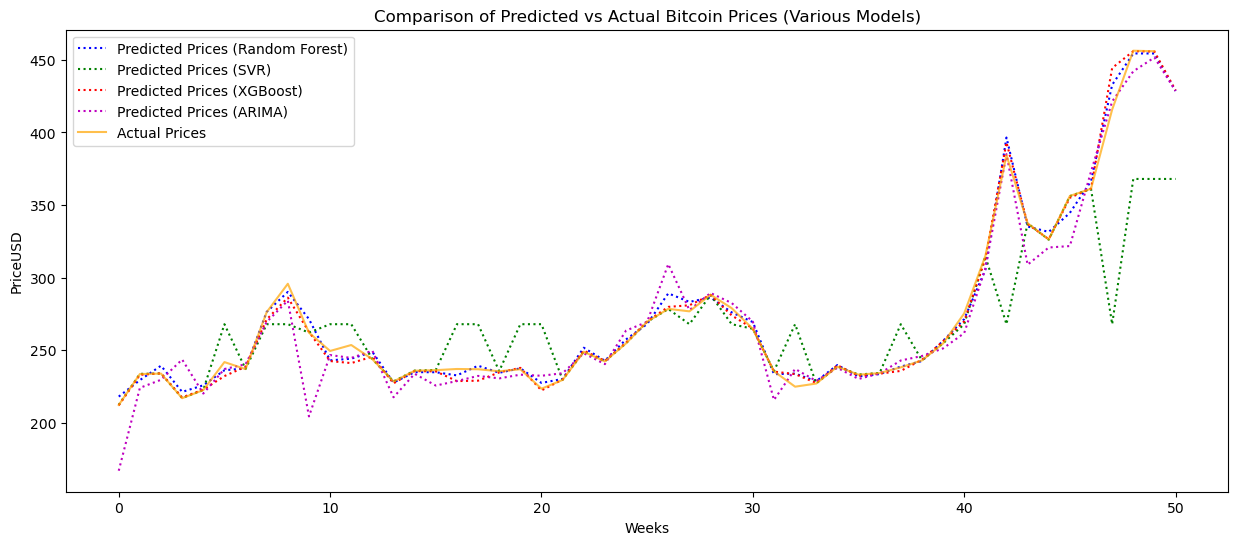

In [43]:

plt.figure(figsize=(15, 6))
plt.plot(predicted_prices_rf, 'b:', label='Predicted Prices (Random Forest)') 
plt.plot(predicted_prices_svr, 'g:', label='Predicted Prices (SVR)')  
plt.plot(predicted_prices_xgbr, 'r:', label='Predicted Prices (XGBoost)') 
plt.plot(predicted_prices_arima, 'm:', label='Predicted Prices (ARIMA)') 
plt.plot(actual_prices, 'orange', label='Actual Prices', alpha=0.7)
plt.xlabel('Weeks')
plt.ylabel('PriceUSD')
plt.title('Comparison of Predicted vs Actual Bitcoin Prices (Various Models)')
plt.legend()
plt.show()


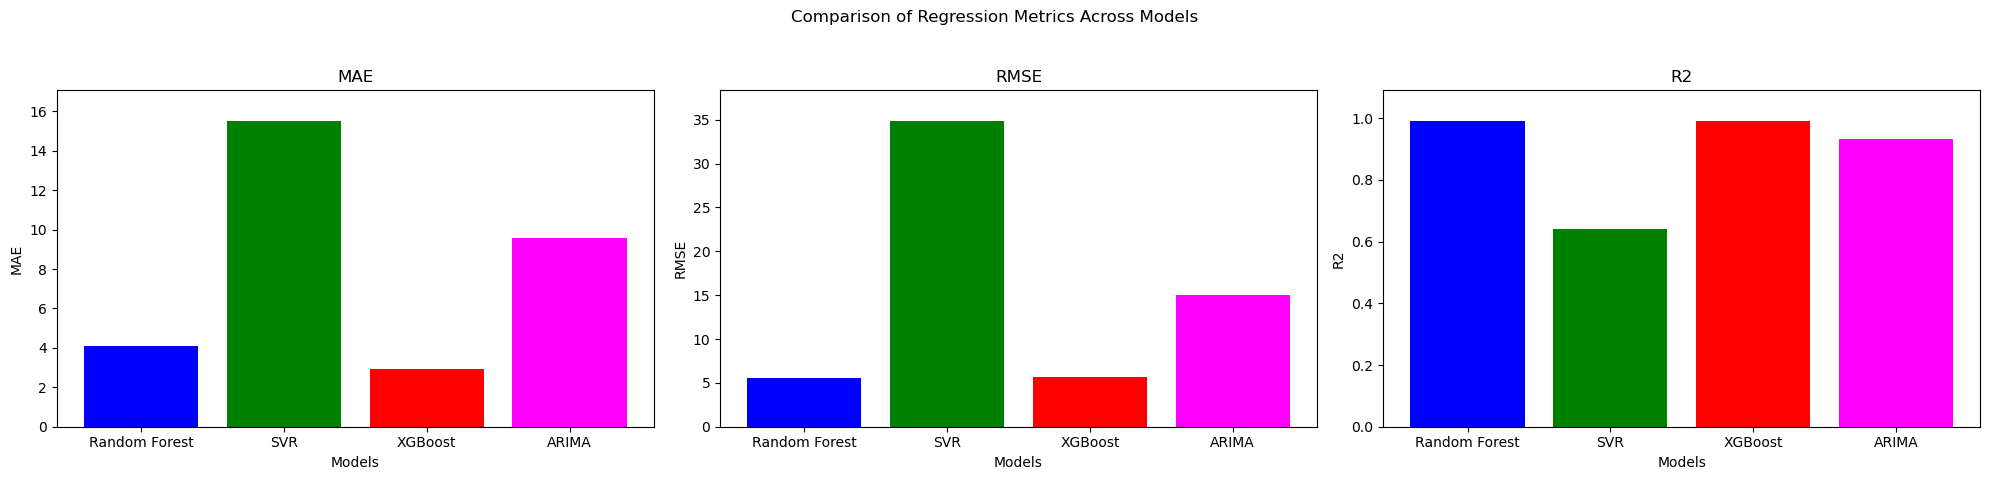

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_regression_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mae, rmse, r2

length_actual = len(actual_prices)-1
actual_prices_truncated = actual_prices[:length_actual]
predicted_prices_rf_truncated = predicted_prices_rf[:length_actual]
predicted_prices_svr_truncated = predicted_prices_svr[:length_actual]
predicted_prices_xgbr_truncated = predicted_prices_xgbr[:length_actual]
predicted_prices_arima_truncated = predicted_prices_arima[:length_actual]

metrics_rf = calculate_regression_metrics(actual_prices_truncated, predicted_prices_rf_truncated)
metrics_svr = calculate_regression_metrics(actual_prices_truncated, predicted_prices_svr_truncated)
metrics_xgbr = calculate_regression_metrics(actual_prices_truncated, predicted_prices_xgbr_truncated)
metrics_arima = calculate_regression_metrics(actual_prices_truncated, predicted_prices_arima_truncated)

metric_names = ['MAE', 'RMSE', 'R2']
models = ['Random Forest', 'SVR', 'XGBoost', 'ARIMA']
all_metrics = [metrics_rf, metrics_svr, metrics_xgbr, metrics_arima]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)  # Set sharey to False
fig.suptitle('Comparison of Regression Metrics Across Models')

for idx, metric in enumerate(metric_names):
    values = [metrics[idx] for metrics in all_metrics]
    axes[idx].bar(models, values, color=['blue', 'green', 'red', 'magenta'])
    axes[idx].set_title(metric)
    axes[idx].set_xlabel('Models')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, max(values)+(0.1*max(values))])  # Set y limits for each subplot

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
